# Ruble Volatility Project — Part 2: Exploratory Data Analysis

This notebook continues the Ruble Volatility Project by exploring trends and patterns in the cleaned dataset prepared in Part 1.

In this notebook (`02_Exploratory_Data_Analysis.ipynb`), I will:

1. Visualize historical trends in the ruble exchange rate (RUB/USD)
2. Compare RUB movements to key macroeconomic indicators (GDP, FDI, inflation, oil prices)
3. Analyze volatility across time, including crisis years
4. Explore structural breaks, rolling statistics, and correlations
5. Prepare data for forecasting and causal inference in future notebooks

**The main modeling and forecasting work will be carried out in the next notebooks, starting with** `03_Time_Series_Modeling.ipynb`.

In [60]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [61]:
# Import the pandas_market_calendars module
# > Note: Some forecasting libraries are imported here in advance for use in Part 3 of the project.

%pip install pandas_market_calendars
import pandas_market_calendars as mcal
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


Note: you may need to restart the kernel to use updated packages.


### I. Loading data

Loading raw RUB exchange rate and macroeconomic data prepared in the previous notebook.

In [62]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Daily_Data2.csv", parse_dates=["date"])
data

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,125.2600,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,134.8000,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
2,130.5000,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
3,130.3000,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
4,130.2000,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7666,80.3466,2025-08-19,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7667,80.1045,2025-08-20,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000
7668,80.2548,2025-08-21,2025,8,14260.000000,67.83,8.200000,3.300000e+09,8.140000


**Data Format Notes:**  
- `currency_rate`: RUB per 1 USD  
- `GDP_per_capita`: current US dollars  
- `Brent_price`: USD per barrel  
- `GDP_deflator` & `Inflation`: percentage (%)  
- `FD_investment`: **billions** of US dollars

### II. Data Quality Assessment

In [63]:
# double-checking for any NAs
print(data.isna().sum())

currency_rate     0
date              0
year              0
month             0
GDP_per_capita    0
Brent_price       0
GDP_deflator      0
FD_investment     0
Inflation         0
dtype: int64


Detect gaps or irregularities across all years

In [64]:
data = data.sort_values("date")
full_range = pd.date_range(start=data["date"].min(), end=data["date"].max(), freq="D")
missing_dates = full_range.difference(data["date"])
print(f"Missing dates: {len(missing_dates)}")
print(missing_dates)

Missing dates: 4436
DatetimeIndex(['1992-07-02', '1992-07-04', '1992-07-05', '1992-07-06',
               '1992-07-07', '1992-07-09', '1992-07-11', '1992-07-12',
               '1992-07-13', '1992-07-14',
               ...
               '2025-07-19', '2025-07-20', '2025-07-26', '2025-07-27',
               '2025-08-02', '2025-08-03', '2025-08-09', '2025-08-10',
               '2025-08-16', '2025-08-17'],
              dtype='datetime64[ns]', length=4436, freq=None)


In [65]:
try:
    import holidays
    ru_holidays = holidays.RU(years=range(1992, 2026))
    missing_df = pd.DataFrame({'date': missing_dates})
    missing_df["is_holiday"] = missing_df["date"].isin(ru_holidays)
except ImportError:
    print("holidays not installed; skipping holiday flag.")
    missing_df = pd.DataFrame({'date': missing_dates})
    missing_df["is_holiday"] = False

# add weekday number (0=Mon, 6=Sun)
missing_df["weekday"] = missing_df["date"].dt.weekday

# add weekend flag
missing_df["is_weekend"] = missing_df["weekday"] >= 5  # Saturday or Sunday

print(missing_df[["is_holiday", "is_weekend"]].value_counts())

is_holiday  is_weekend
False       False         2083
            True          1924
True        False          342
            True            87
Name: count, dtype: int64


In [66]:
missing_df[missing_df["date"].dt.year == 2025]

,date,is_holiday,weekday,is_weekend
4371,2025-01-01,True,2,False
4372,2025-01-02,True,3,False
4373,2025-01-04,True,5,True
4374,2025-01-05,True,6,True
4375,2025-01-07,True,1,False
...,...,...,...,...
4431,2025-08-03,False,6,True
4432,2025-08-09,False,5,True
4433,2025-08-10,False,6,True
4434,2025-08-16,False,5,True


In [67]:
counts = missing_df[["is_holiday", "is_weekend"]].value_counts()

count_weekday_only = counts.loc[(False, False)]
count_weekend_only = counts.loc[(False, True)]
count_holiday_only = counts.loc[(True, False)]
count_holiday_and_weekend = counts.loc[(True, True)]

print(f"{count_weekday_only} Missing dates that are regular weekdays and not holidays — these are unexplained gaps that could signal missing data or non-trading days.")
print(f"{count_weekend_only} Missing dates that fell on weekends but were not official holidays. Also considered normal missingness for daily financial data.")
print(f"{count_holiday_only} Missing dates that were official Russian holidays, but not weekends. These are justified gaps.")
print(f"{count_holiday_and_weekend} Missing dates that were both holidays and weekends. Double justification.")

2083 Missing dates that are regular weekdays and not holidays — these are unexplained gaps that could signal missing data or non-trading days.
1924 Missing dates that fell on weekends but were not official holidays. Also considered normal missingness for daily financial data.
342 Missing dates that were official Russian holidays, but not weekends. These are justified gaps.
87 Missing dates that were both holidays and weekends. Double justification.


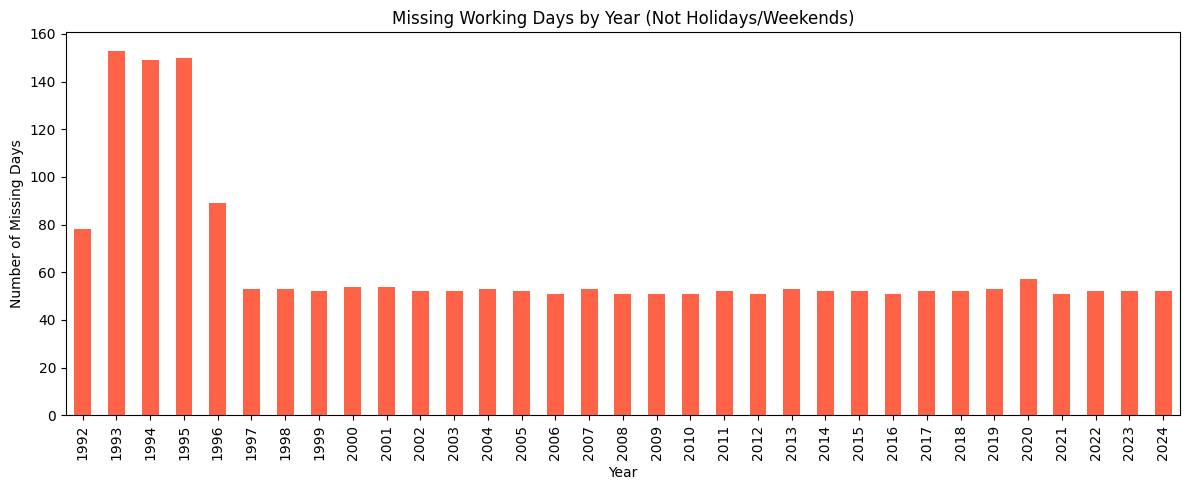

In [68]:
working_day_gaps['year'] = working_day_gaps['date'].dt.year
missing_by_year = working_day_gaps['year'].value_counts().sort_index()
missing_by_year.plot(kind='bar', figsize=(12, 5), color='tomato')
plt.title('Missing Working Days by Year (Not Holidays/Weekends)')
plt.xlabel('Year')
plt.ylabel('Number of Missing Days')
plt.tight_layout()
plt.show()

I examined 2,083 missing trading days that were **neither holidays nor weekends**. The analysis revealed:


- A large concentration of missing working days occurred between 1992–1996, likely due to post-Soviet disruptions in financial infrastructure.
- From 1997 onward, missing data stabilizes around ~55 days per year, suggesting more consistent data collection.
- A slight uptick around 2020–2021 may be linked to the COVID-19 pandemic.

These patterns suggest that early years (1992–1996) require caution due to potential data unreliability, possibly tied to political and institutional transitions. However, most years after 1997 show stable data, making them suitable for time series modeling, volatility analysis, and event studies.

A question is: **Can we continue working with this data?**

Yes, but we should be careful with the years 1992–1996, since there are a lot of missing days likely due to instability after the Soviet Union collapsed.
We can either exclude these years from modeling or add a flag to account for them. I will continue my analysis and apply the appropriate approach later in this notebook.

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7670 entries, 0 to 7669
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   currency_rate   7670 non-null   float64       
 1   date            7670 non-null   datetime64[ns]
 2   year            7670 non-null   int64         
 3   month           7670 non-null   int64         
 4   GDP_per_capita  7670 non-null   float64       
 5   Brent_price     7670 non-null   float64       
 6   GDP_deflator    7670 non-null   float64       
 7   FD_investment   7670 non-null   float64       
 8   Inflation       7670 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 599.2 KB


In [70]:
data.describe()

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
count,7670.000000,7670,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7.670000e+03,7670.000000
mean,464.412233,2010-02-24 10:21:26.049543680,2009.638592,6.655541,8572.722279,58.639331,42.715935,1.975617e+10,42.714613
min,5.960000,1992-07-01 00:00:00,1992.000000,1.000000,1330.757202,9.910000,0.898246,-3.980094e+10,0.898246
25%,28.670200,2002-06-27 06:00:00,2002.000000,4.000000,2930.670166,27.560000,7.490071,2.847300e+09,7.490071
50%,32.795300,2010-03-11 12:00:00,2010.000000,7.000000,9277.713867,59.090000,14.191110,9.478810e+09,14.191110
75%,72.388225,2017-11-29 18:00:00,2017.000000,10.000000,12425.029297,80.370000,18.538967,3.759477e+10,18.538967
max,5960.000000,2025-08-22 00:00:00,2025.000000,12.000000,15941.448242,138.400000,1490.418425,7.478291e+10,1490.418425
std,1388.749361,NaN,9.026007,3.393557,4951.677498,31.977625,160.131182,2.496022e+10,160.131467



* `RUB/USD exchange rate (currency_rate)` spans from ~6 to 5,960 with a median around 33, a huge spread reflecting redenomination and multiple crises. Standard deviation (~1,389) confirms extreme volatility 

* `GDP per capita` rose from ~1,300 to ~15,900 USD, showing long‑term growth but with large variation (std ~4,950)

* `Brent oil price` ranges from ~$10 to ~$138 with a mean of ~$59, clearly capturing oil booms and crashes

* `Inflation and GDP deflator` show very high peaks (max ~1,490%) consistent with early‑1990s hyperinflation; large std devs indicate strong instability

* `FDI` fluctuates sharply between large outflows (–$39 B) and inflows (+$74 B), showing high volatility of capital movement

Takeaway: All core variables are highly variable and non‑stationary, which makes transformations (log, differencing) and careful time‑series modeling essential.

### II. Unique values for categorical features

As we can see above, the currency_rate column shows extreme variation. On January 1, 1998, the Russian government implemented a 1,000:1 currency redenomination, replacing old banknotes with new ones to simplify the monetary system after a period of high inflation.

This creates a structural break in the time series, which needs to be carefully handled for any analysis or modeling.

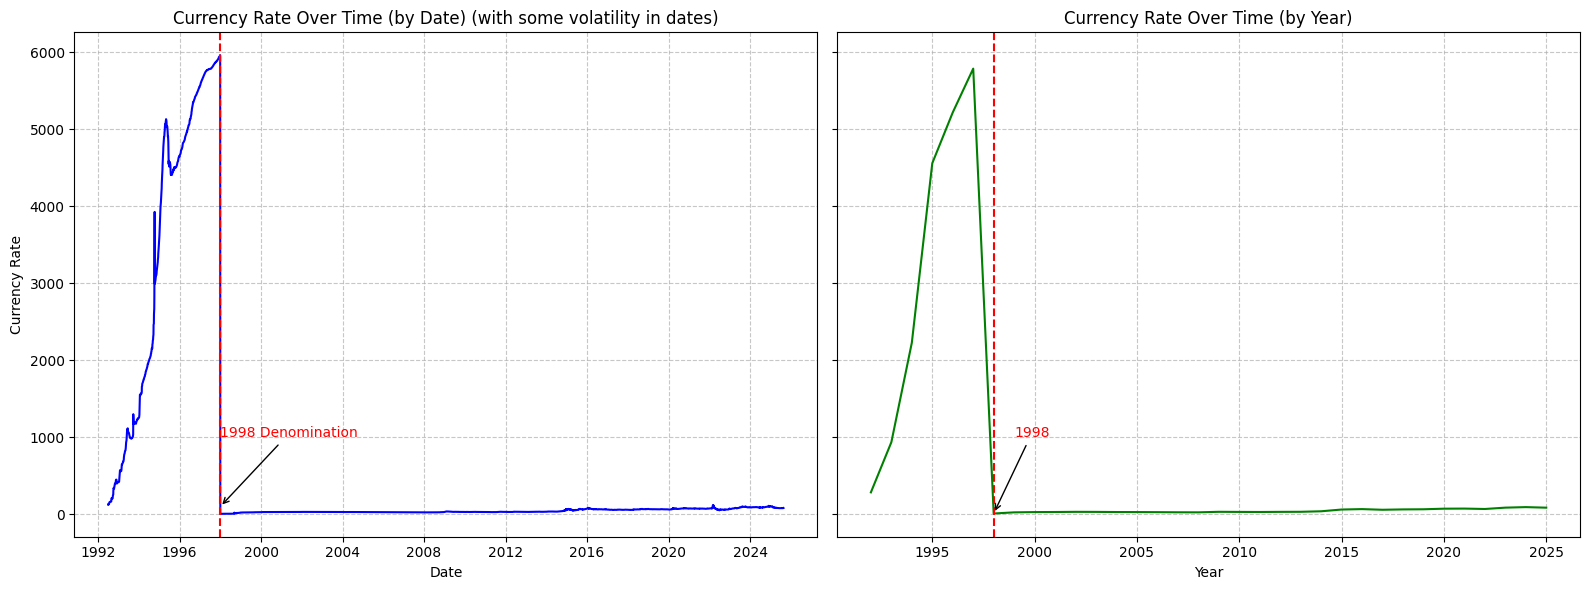

In [71]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="currency_rate", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)


denom_date = pd.to_datetime("1998-01-01")
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, 100), 
                xytext=(denom_date, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['currency_rate'].mean()
sns.lineplot(data=yearly, x="year", y="currency_rate", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)

# 1998
axs[1].axvline(1998, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998", 
                xy=(1998, yearly[yearly["year"] == 1998]["currency_rate"].values[0]),
                xytext=(1999, 1000),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [72]:
data['currency_rate_change'] = data['currency_rate'].pct_change() * 100

# find the date with the largest absolute percentage change
significant_change = data.loc[data['currency_rate_change'].abs().idxmax()]
significant_change_date = significant_change['date']
significant_change_value = significant_change['currency_rate_change']

significant_change_date, significant_change_value

(Timestamp('1998-01-01 00:00:00'), -99.9)

This adjustment is clearly visible in the data, with a sharp drop in the exchange rate between December 30, 1997, and January 1, 1998.

In [73]:
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change
794,5955.000,1997-12-25,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.084034
795,5955.000,1997-12-26,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.000000
796,5958.000,1997-12-27,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.050378
797,5960.000,1997-12-30,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.033568
798,5.960,1998-01-01,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,-99.900000
799,5.963,1998-01-06,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.050336
800,5.969,1998-01-07,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.100620


#### Structural Flags: Pre/Post Denomination and Early Data Disruption

To account for known breaks in the data and improve model performance, I create two new columns:

1. **`denomination`**  
   Labels each observation based on whether it occurred before or after the 1998 ruble denomination:
   - "pre" for dates on or before 1997-12-30 (old rubles)
   - "post" for dates after that (new rubles)  
   This helps the model handle the sharp numerical shift in exchange rate levels after the currency reform.

2. **`post_soviet_disruption`**  
   Flags whether the date falls in the 1992–1996 range — the early post-Soviet period.  
   This period showed unusually high numbers of missing working days (see bar chart above), reflecting poor data quality and unstable market conditions.  
   The column is binary:
   - 1 for years 1992–1996
   - 0 otherwise

These flags won’t “fix” the breaks in the data but will let downstream models adjust for structural changes more effectively.

In [74]:
# Add dummy column for post_soviet_disruption
data["sov_disrupt"] = np.where((data["year"] >= 1992) & (data["year"] <= 1996), 1, 0)
data.head()

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1


In [ ]:
# label data with pre and post denomination
data["denomination"] = np.where(data["date"] <= "1997-12-30", "pre", "post")

# normilize currency rate
data["RUB"] = np.where(data["denomination"] == "pre", data["currency_rate"]/1000, data["currency_rate"])
data[(data["date"] >= "1997-12-25") & (data["date"] <= "1998-01-08")]

,currency_rate,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
794,5955.000,1997-12-25,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.084034,0,pre,5.955
795,5955.000,1997-12-26,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.000000,0,pre,5.955
796,5958.000,1997-12-27,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.050378,0,pre,5.958
797,5960.000,1997-12-30,1997,12,2737.572021,15.86,15.058504,4.864650e+09,15.058504,0.033568,0,pre,5.960
798,5.960,1998-01-01,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,-99.900000,0,post,5.960
799,5.963,1998-01-06,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.050336,0,post,5.963
800,5.969,1998-01-07,1998,1,1834.861816,15.59,18.538967,2.761360e+09,18.538967,0.100620,0,post,5.969


In [93]:
data = data.rename(columns={"currency_rate": "old_RUB"})
data.head()

,old_RUB,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1,pre,0.12526
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1,pre,0.13480
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1,pre,0.13050
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1,pre,0.13030
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1,pre,0.13020


After correcting and normalizing data plots looking better.

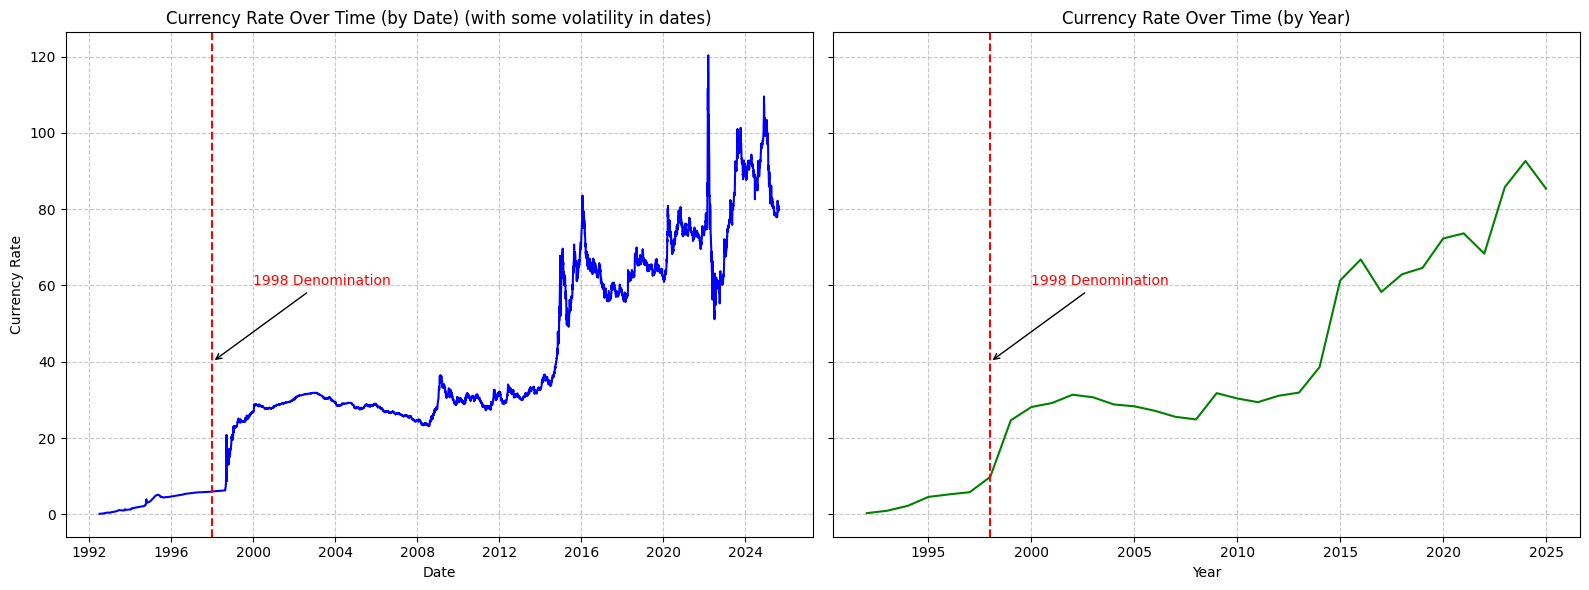

In [94]:
data['year'] = pd.to_datetime(data['date']).dt.year
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

denom_date = pd.to_datetime("1998-01-01")
arrow_y = 40
text_y = 60
text_x = pd.to_datetime("2000-01-01")

# Plot 1: Full date-level currency rate
sns.lineplot(data=data, x="date", y="RUB", ax=axs[0], color="blue")
axs[0].set_title("Currency Rate Over Time (by Date) (with some volatility in dates)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Currency Rate")
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].axvline(denom_date, color="red", linestyle="--", linewidth=1.5)
axs[0].annotate("1998 Denomination", 
                xy=(denom_date, arrow_y), 
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")



# Plot 2: Year-level average currency rate
yearly = data.groupby('year', as_index=False)['RUB'].mean()
sns.lineplot(data=yearly, x="year", y="RUB", ax=axs[1], color="green")
axs[1].set_title("Currency Rate Over Time (by Year)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("")
axs[1].grid(True, linestyle="--", alpha=0.7)
arrow_year = 1998
text_year = 2000
axs[1].axvline(arrow_year, color="red", linestyle="--", linewidth=1.5)
axs[1].annotate("1998 Denomination", 
                xy=(arrow_year, arrow_y), 
                xytext=(text_year, text_y),
                arrowprops=dict(facecolor="red", arrowstyle="->"),
                fontsize=10, color="red")

plt.tight_layout()
plt.show()

In [78]:
data_year = data.groupby("year").agg({"RUB": "mean"}).reset_index()
data_year.head()

,year,RUB
0,1992,0.284345
1,1993,0.936061
2,1994,2.227129
3,1995,4.558707
4,1996,5.217653


The chart shows the long-term trend of the ruble over the years. After its denomination in 1998, the ruble gradually depreciated, with periods of relative stability followed by renewed declines. Overall, the currency has shown a clear tendency to weaken over time, reflecting broader economic and structural challenges.


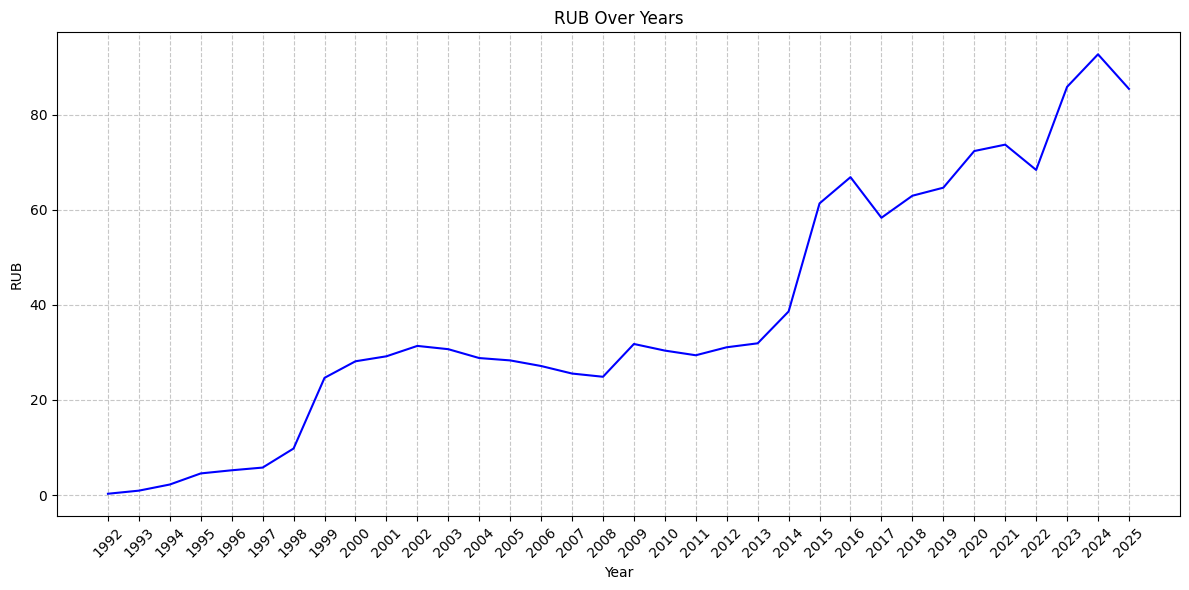

In [95]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_year, x="year", y="RUB", color="blue")

plt.xlabel("Year")
plt.ylabel("RUB")
plt.title("RUB Over Years")
plt.xticks(ticks=data_year["year"], labels=data_year["year"], rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### III. Key Events Shaping the Ruble

Now, to better understand the main drivers of ruble fluctuations, I highlight several major economic and geopolitical shocks on the timeline.
These events represent turning points where external crises or domestic policies significantly impacted the ruble’s trajectory:
* 1998 Default – August 17, 1998
* 2008 Global Financial Crisis – September 15, 2008
* 2014 Crimea – March 1, 2014
* 2020 COVID-19 Pandemic – March 11, 2020
* 2022 Russian Invasion of Ukraine – February 24, 2022

The following chart overlays these shocks on the ruble’s historical path to illustrate how closely currency movements align with key crises.

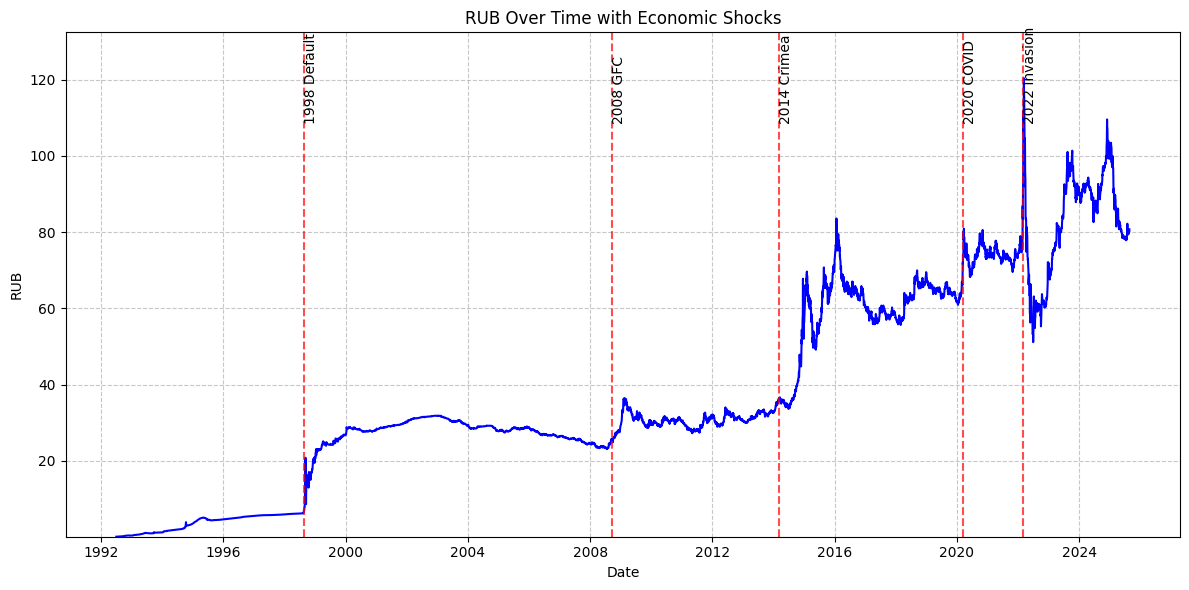

In [96]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="date", y="RUB", color="blue")

for label, date in shocks.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), data['RUB'].max() * 0.9, label, rotation=90, verticalalignment='bottom')


plt.ylim(data['RUB'].min() * 0.9, data['RUB'].max() * 1.1)
plt.xlabel("Date")
plt.ylabel("RUB")
plt.title("RUB Over Time with Economic Shocks")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Each crisis left a lasting mark, pushing the currency to a new, weaker baseline rather than fully reverting. This pattern suggests that the ruble is highly sensitive to external pressures — both economic (global financial crises, oil prices) and geopolitical (sanctions, conflicts). Instead of smooth cyclical behavior, the ruble evolves through structural breaks that reset its long-term trajectory.

### IV. Time Series Plots

#### Converting Data to Monthly Frequency

As mentioned in the [01_Data_Input_and_Cleaning.ipynb](01_Data_Input_and_Cleaning.ipynb) notebook, I merged annual macroeconomic indicators with daily-level ruble data using forward-fill by year approach. While this allowed for merging across different frequencies, it doesn’t reflect any **intra-year macroeconomic changes**.

In this notebook, I now resample the data to monthly frequency by aggregating the daily RUB exchange rate, essentially applying **approach #4, Aggregate RUB to monthly, forward-fill macro"**. This adjustment provides a more stable and interpretable foundation for exploratory data analysis and time series modeling, while still retaining enough granularity to capture meaningful trends and shocks. 

What to keep in mind: 

- Loses some high-frequency detail
- May smooth out short-lived shocks or volatility

Final Setup:

* RUB exchange rate: Aggregated using monthly mean → smooths short-term volatility while preserving overall trends.
* Annual macro data (GDP, FDI, inflation): Forward-filled across each year → monthly mean reflects the correct annual value.
* Monthly macro data (oil prices): Forward-filled across each month → monthly mean recovers original monthly values.
* Dummy variables (e.g., post_denom, post_soviet_disruption): Categorical → last value of the month is retained, which preserves logical labels.


Yet, I will retain both versions (daily and monthly) throughout the project depending on context.

In [97]:
data.head()

,old_RUB,date,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
0,125.26,1992-07-01,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,1,pre,0.12526
1,134.80,1992-07-03,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,7.616158,1,pre,0.13480
2,130.50,1992-07-08,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-3.189911,1,pre,0.13050
3,130.30,1992-07-10,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.153257,1,pre,0.13030
4,130.20,1992-07-15,1992,7,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,-0.076746,1,pre,0.13020


In [99]:
data['date'] = pd.to_datetime(data['date'])

data_monthly = data.set_index('date').resample('M').agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[-1]).reset_index()

# Save the monthly-aggregated data for further analysis
data_monthly.to_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv", index=False)
data_monthly.tail()

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB
393,2025-04-30,83.243645,2025.0,4.0,14260.0,63.37,8.2,3.300000e+09,8.14,-0.213785,0.0,post,83.243645
394,2025-05-31,80.237650,2025.0,5.0,14260.0,64.32,8.2,3.300000e+09,8.14,-0.178412,0.0,post,80.237650
395,2025-06-30,78.677635,2025.0,6.0,14260.0,68.15,8.2,3.300000e+09,8.14,-0.004909,0.0,post,78.677635
396,2025-07-31,78.850139,2025.0,7.0,14260.0,73.43,8.2,3.300000e+09,8.14,0.101659,0.0,post,78.850139
397,2025-08-31,80.013656,2025.0,8.0,14260.0,67.83,8.2,3.300000e+09,8.14,0.034674,0.0,post,80.013656


#### Basic Time-Series Plots

In [117]:
# adding Macro Metrcis for plots

macro_vars = [
    ("GDP_per_capita", "GDP per Capita (USD)"),
    ("FD_investment", "Foreign Direct Investment (USD)"),
    ("Brent_price", "Brent Oil Price (USD/barrel)"),
    ("GDP_deflator", "GDP Deflator"),
    ("Inflation", "Inflation (%)"),
]

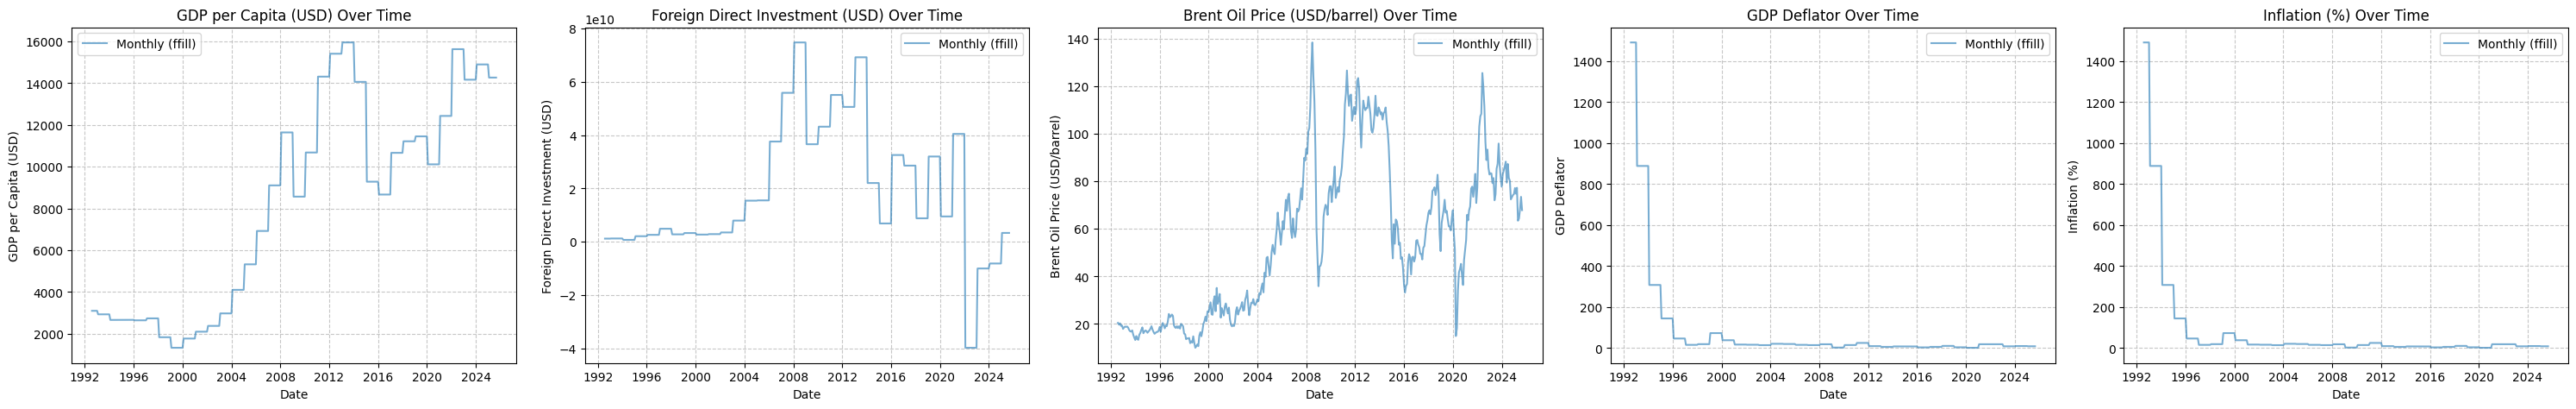

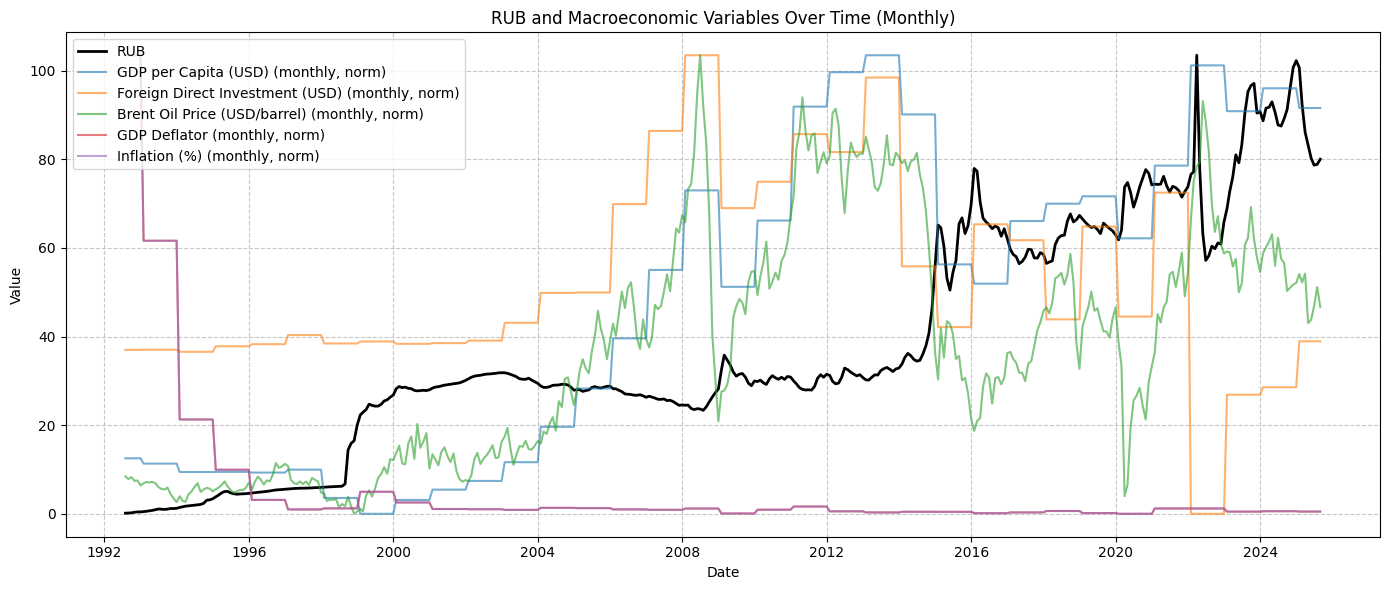

In [119]:
n_vars = len(macro_vars)
fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 5), sharex=True)
if n_vars == 1:
    axes = [axes]
for ax, (var, label) in zip(axes, macro_vars):
    # Plot only monthly-resampled (forward-filled) series
    ax.plot(data_monthly["date"], data_monthly[var], label="Monthly (ffill)", color="tab:blue", alpha=0.6)
    ax.set_xlabel("Date")
    ax.set_ylabel(label)
    ax.set_title(f"{label} Over Time")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(data_monthly["date"], data_monthly["RUB"], label="RUB", color="black", linewidth=2)

for var, label in macro_vars:
    # normalize for monthly
    norm_monthly = (data_monthly[var] - data_monthly[var].min()) / (data_monthly[var].max() - data_monthly[var].min())
    plt.plot(data_monthly["date"], norm_monthly * data_monthly["RUB"].max(), label=f"{label} (monthly, norm)", alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("RUB and Macroeconomic Variables Over Time (Monthly)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

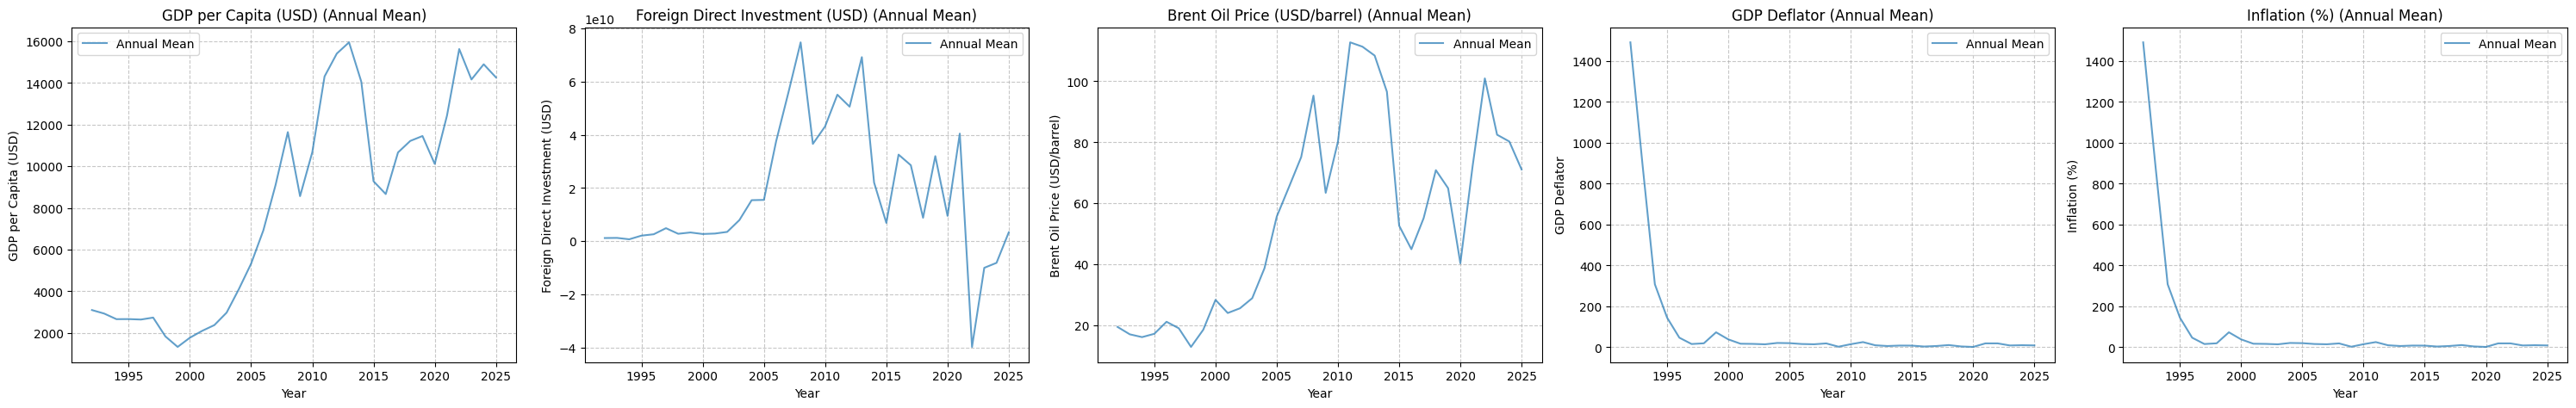

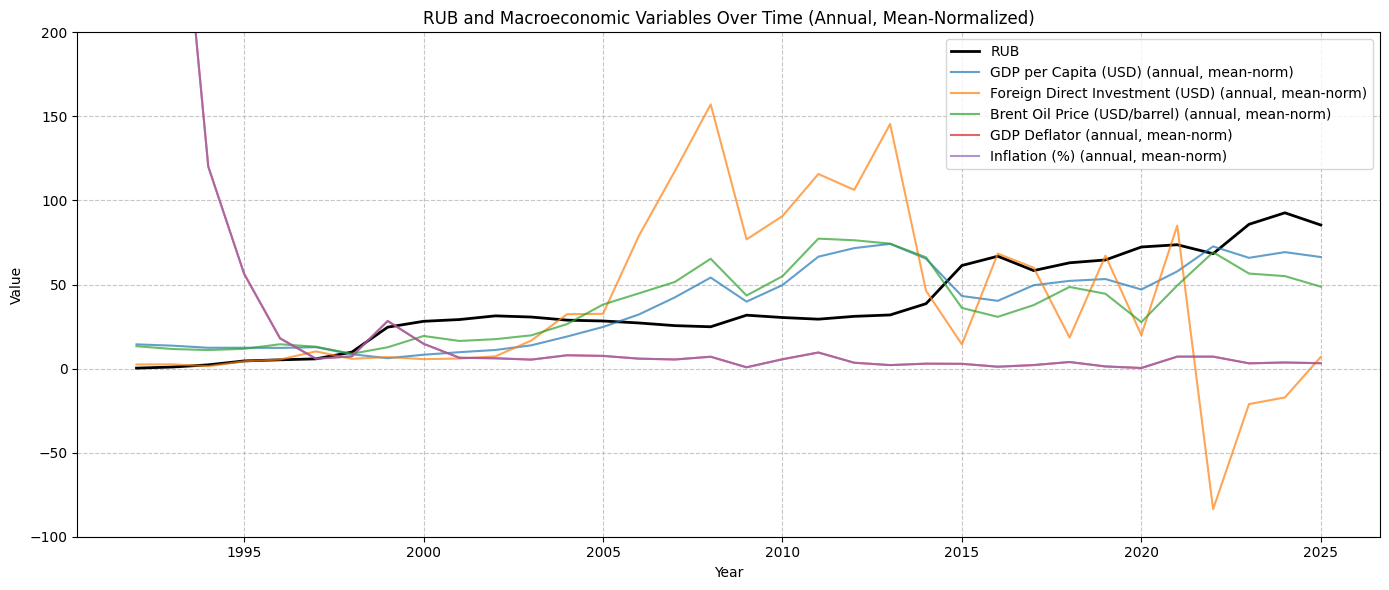

In [114]:
# Annual Time Series Plots for Macroeconomic Variables (side-by-side) using annual means
# Value should be from -100 till 200 for main plot, but for small plots show all data

macro_vars = [
    ("GDP_per_capita", "GDP per Capita (USD)"),
    ("FD_investment", "Foreign Direct Investment (USD)"),
    ("Brent_price", "Brent Oil Price (USD/barrel)"),
    ("GDP_deflator", "GDP Deflator"),
    ("Inflation", "Inflation (%)"),
]

# Compute annual means for all variables of interest, including RUB
annual_data = data.groupby("year").agg({**{var: "mean" for var, _ in macro_vars}, "RUB": "mean"}).reset_index()

n_vars = len(macro_vars)
fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 5), sharex=True)
if n_vars == 1:
    axes = [axes]
for ax, (var, label) in zip(axes, macro_vars):
    ax.plot(annual_data["year"], annual_data[var], label="Annual Mean", color="tab:blue", alpha=0.7)
    ax.set_xlabel("Year")
    ax.set_ylabel(label)
    ax.set_title(f"{label} (Annual Mean)")
    # Do NOT set ylim here, so all data is visible
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
plt.tight_layout()
plt.show()

# Combined plot: RUB and selected macro variables for visual comparison (annual only, mean-normalized)
plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB"], label="RUB", color="black", linewidth=2)

for var, label in macro_vars:
    # Normalize by mean for visual comparison (annual only)
    norm_annual = annual_data[var] / annual_data[var].mean()
    plt.plot(annual_data["year"], norm_annual * annual_data["RUB"].mean(), label=f"{label} (annual, mean-norm)", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("RUB and Macroeconomic Variables Over Time (Annual, Mean-Normalized)")
plt.ylim(-100, 200)  # Only restrict y-limits for the main combined plot
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

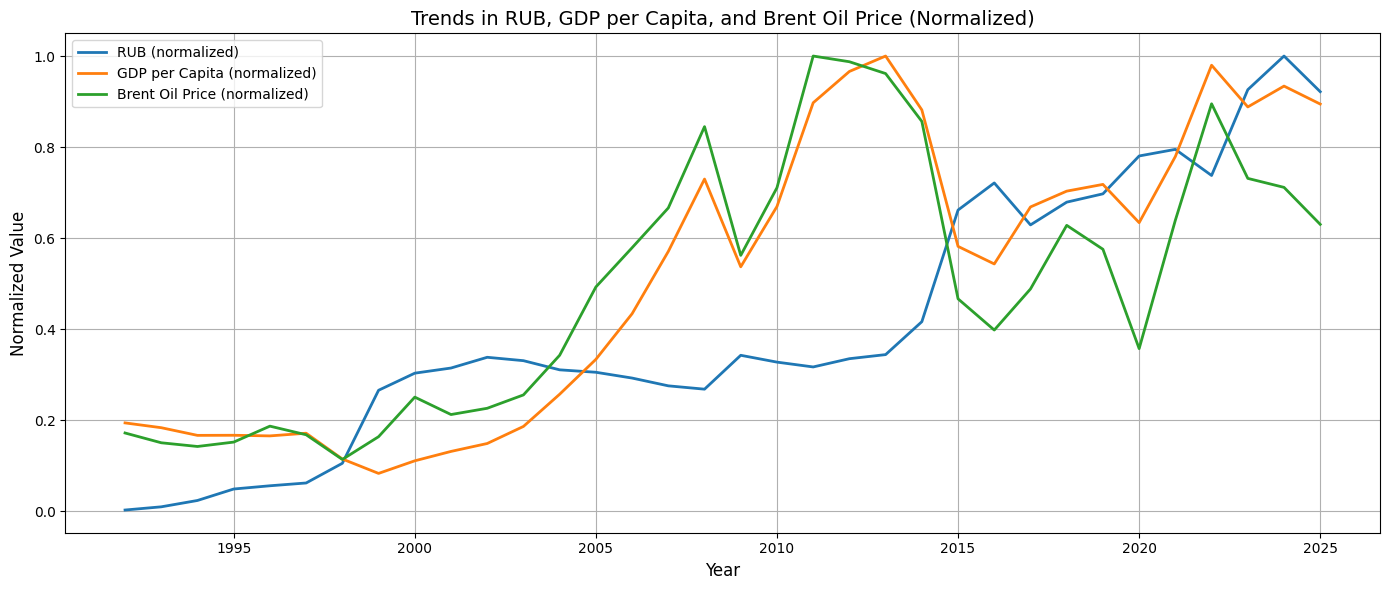

In [ ]:
annual_data = data.groupby("year").agg({
    "RUB": "mean",
    "GDP_per_capita": "mean",
    "Brent_price": "mean"
}).reset_index()


annual_data["RUB_norm"] = annual_data["RUB"] / annual_data["RUB"].max()
annual_data["GDP_norm"] = annual_data["GDP_per_capita"] / annual_data["GDP_per_capita"].max()
annual_data["Brent_norm"] = annual_data["Brent_price"] / annual_data["Brent_price"].max()


plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB_norm"], label="RUB (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["GDP_norm"], label="GDP per Capita (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Brent_norm"], label="Brent Oil Price (normalized)", linewidth=2)


plt.title("Trends in RUB, GDP per Capita, and Brent Oil Price (Normalized)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

This plot displays the normalized trends of the Russian ruble (RUB) exchange rate, GDP per capita (current US$), and Brent crude oil prices from 1992 to 2025. Normalization allows for comparison across different units by scaling all values between 0 and 1.

Key highlights:
- The **1998 financial crisis** and currency redenomination are clearly visible as sharp movements in the RUB series.
- The **2000s oil boom** shows strong upward trends in both oil prices and GDP per capita, with the ruble also appreciating during this period.
- The **2008 global financial crisis** and the **2014–2015 oil price collapse and sanctions** result in synchronized drops across all three indicators.
- Post-2020, increased **volatility** is observed due to the COVID-19 pandemic, geopolitical tensions, and energy market fluctuations.

This comparison helps illustrate how external shocks (like oil price changes) and internal factors (such as inflation or economic growth) jointly influence the ruble's long-term volatility.

I plan to do this because:
- Monthly data smooths out noise, making **volatility patterns** and **macroeconomic dependencies** easier to explore
- Many EDA methods and time-series models (ARIMA, seasonal decomposition, correlations) work more effectively with **monthly frequency**

### Summary:

This notebook prepared and cleaned historical data for RUB exchange rates and major economic indicators (GDP per capita, FDI, inflation, oil prices). 

Next steps:
- Perform exploratory analysis and correlation studies
- Fit ARIMA/ARIMAX/GARCH models to study ruble volatility
- Run event studies and synthetic control methods to assess causal shocks